# Mask R-CNN - Inspect Nucleus Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [114]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.potato import potato

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [115]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [116]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/potato_2")

# Inference Configuration
config = potato.PotatoConfig()

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time


    NAME = "potato"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
      
    
    
     # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    BACKBONE_STRIDES = [4,8,16,32,64]
    
    ##********** 1)ANCHORS GENERATION - for RPN*********
    
    #     Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 24,32, 48) 
    TOP_DOWN_PYRAMID_SIZE = 256
    
    ##********** 2)PROPOSAL LAYER ********* (no deep learning involved here)
    
     # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 128 ##in dataset generation

    ## tf.image.non_max_suppression(boxes,scores,max_output_size,iou_threshold=0.5,...)
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD=0.5
    #A float representing the threshold for deciding whether boxes overlap too much with respect to IOU.    
    ## POST_NMS_ROIS_TRAINING~ POST_NMS_ROIS_INFERENCE ~proposal_count ~ max_output_size
    
    POST_NMS_ROIS_TRAINING=1500
    POST_NMS_ROIS_INFERENCE=800
    ##********** 3a)TRAINING - DETECTION TARGET LAYER *********
    
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 128
    
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.45
    
    ##********** 3B)INFERENCE - DETECTION  LAYER *********

    # Non-maximum suppression threshold for detection in DetectionLater
    DETECTION_NMS_THRESHOLD=0.8#0.5 above iou_threshold
    
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped in DetectionLater
    DETECTION_MIN_CONFIDENCE=0.9
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 80


    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 30

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    LEARNING_RATE=0.001
    
    
    TRAIN_BN=True
    
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        80
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.8
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [117]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [118]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [119]:
# Load validation dataset
dataset = potato.PotatoDataset()
dataset.load_potato(DATASET_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 70
Classes: ['BG', 'potato']


## Load Model

In [120]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [121]:
# Path to a specific weights file
weights_path =  os.path.join(LOGS_DIR,'potato20190221T1003/mask_rcnn_potato_0054.h5')
# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/meli/Desktop/git/Mask_RCNN/logs/potato20190221T1003/mask_rcnn_potato_0054.h5
Re-starting from epoch 54


## Run Detection

image ID: potato.1162 (69) /home/meli/Desktop/git/Mask_RCNN/datasets/potato_2/images/1162_rgb.tif
Original image shape:  [256 256   3]
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  214.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:   10.00000  max:  214.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.13310  max:    1.01299  float32
gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:    1.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 13)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.777
AP @0.55:	 0.777
AP @0.60:	 0.777
AP @0.65:	 0.730
AP @0.70:	 0.545
AP @0.75:	 0.380
AP @0.80:	 0.159
AP @0.85:	 0.031
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 

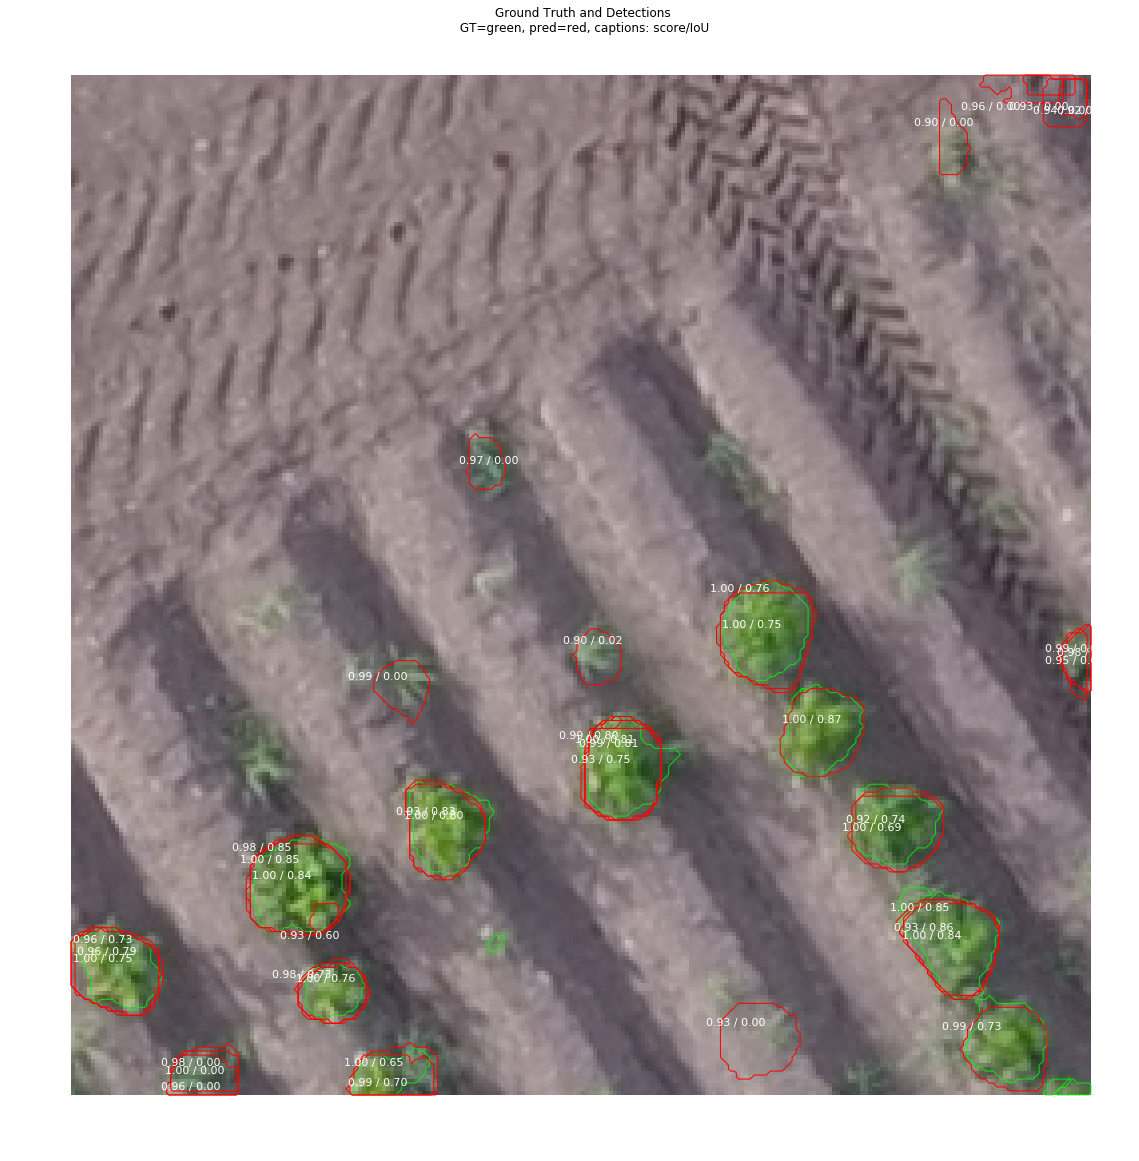

In [122]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.8, score_threshold=0.9)

In [123]:
# Display predictions only
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset.class_names, r['scores'], ax=get_ax(1),
#                             show_bbox=False, show_mask=False,
#                             title="Predictions")

In [124]:
# Display Ground Truth only
# visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset.class_names, ax=get_ax(1),
#                             show_bbox=False, show_mask=False,
#                             title="Ground Truth")

### Compute AP on Batch of Images

In [100]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 70
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [256 256   3]   AP: 0.41
  1 [256 256   3]   AP: 0.00
  2 [256 256   3]   AP: 0.38


KeyboardInterrupt: 

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [125]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (16368, 4)            min:  -34.00000  max:  259.00000  int32
target_rpn_match         shape: (16368,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (128, 4)              min:   -3.46574  max:    3.46574  float64
positive_anchors         shape: (13, 4)               min:    4.00000  max:  256.00000  int32
negative_anchors         shape: (115, 4)              min:   -8.00000  max:  258.00000  int32
neutral anchors          shape: (16240, 4)            min:  -34.00000  max:  259.00000  int32
refined_anchors          shape: (13, 4)               min:    1.00000  max:  256.00000  float32


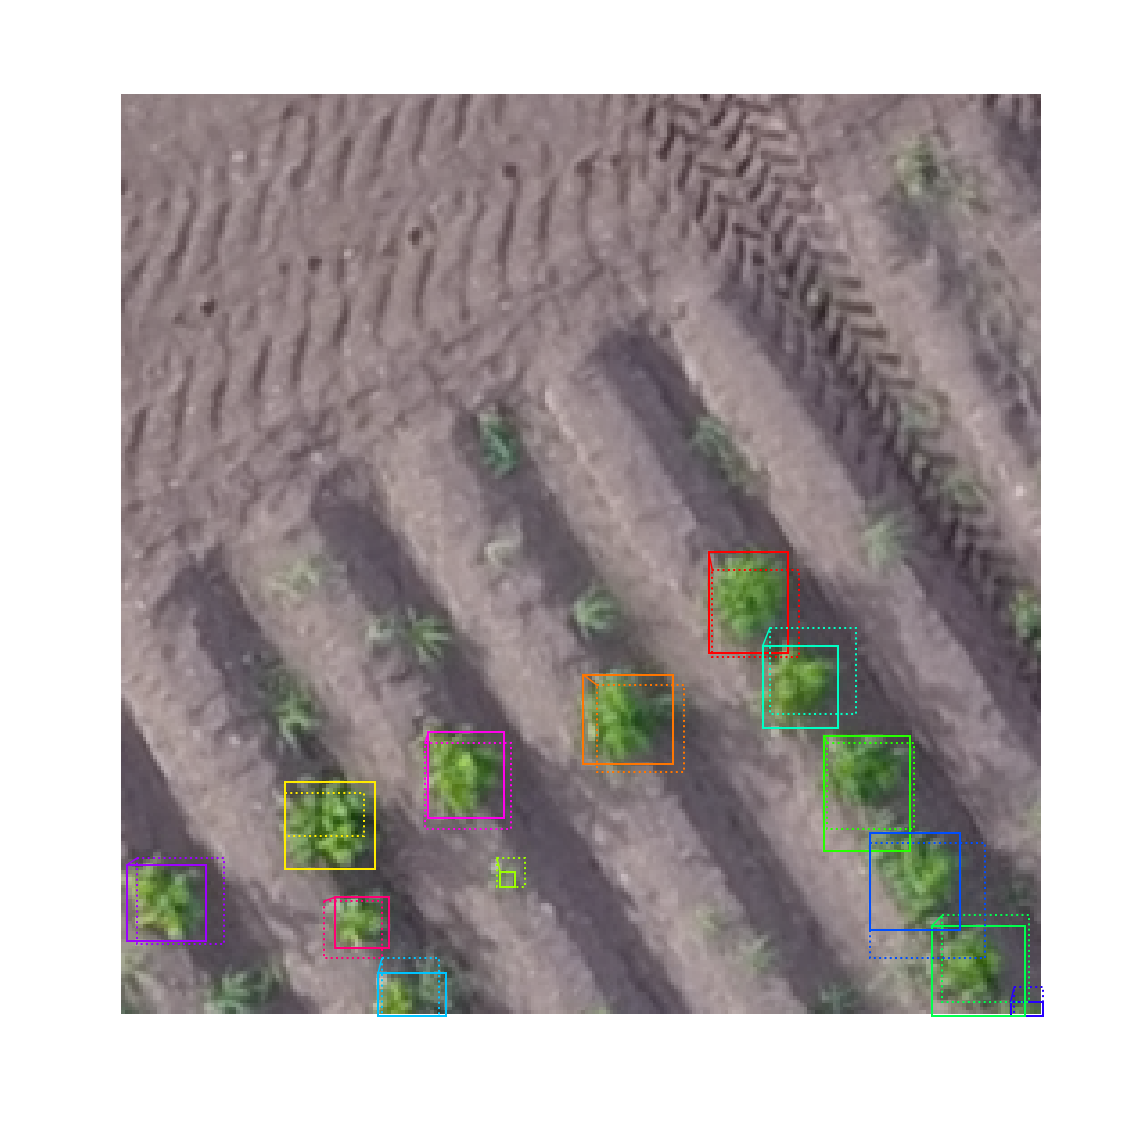

In [126]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [127]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 16368, 2)         min:    0.00001  max:    0.99999  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.13310  max:    1.01299  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.12227  max:    1.00964  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (800,)                min:    0.00000  max: 2013.00000  int32
proposals                shape: (1, 800, 4)           min:    0.00000  max:    1.00000  float32


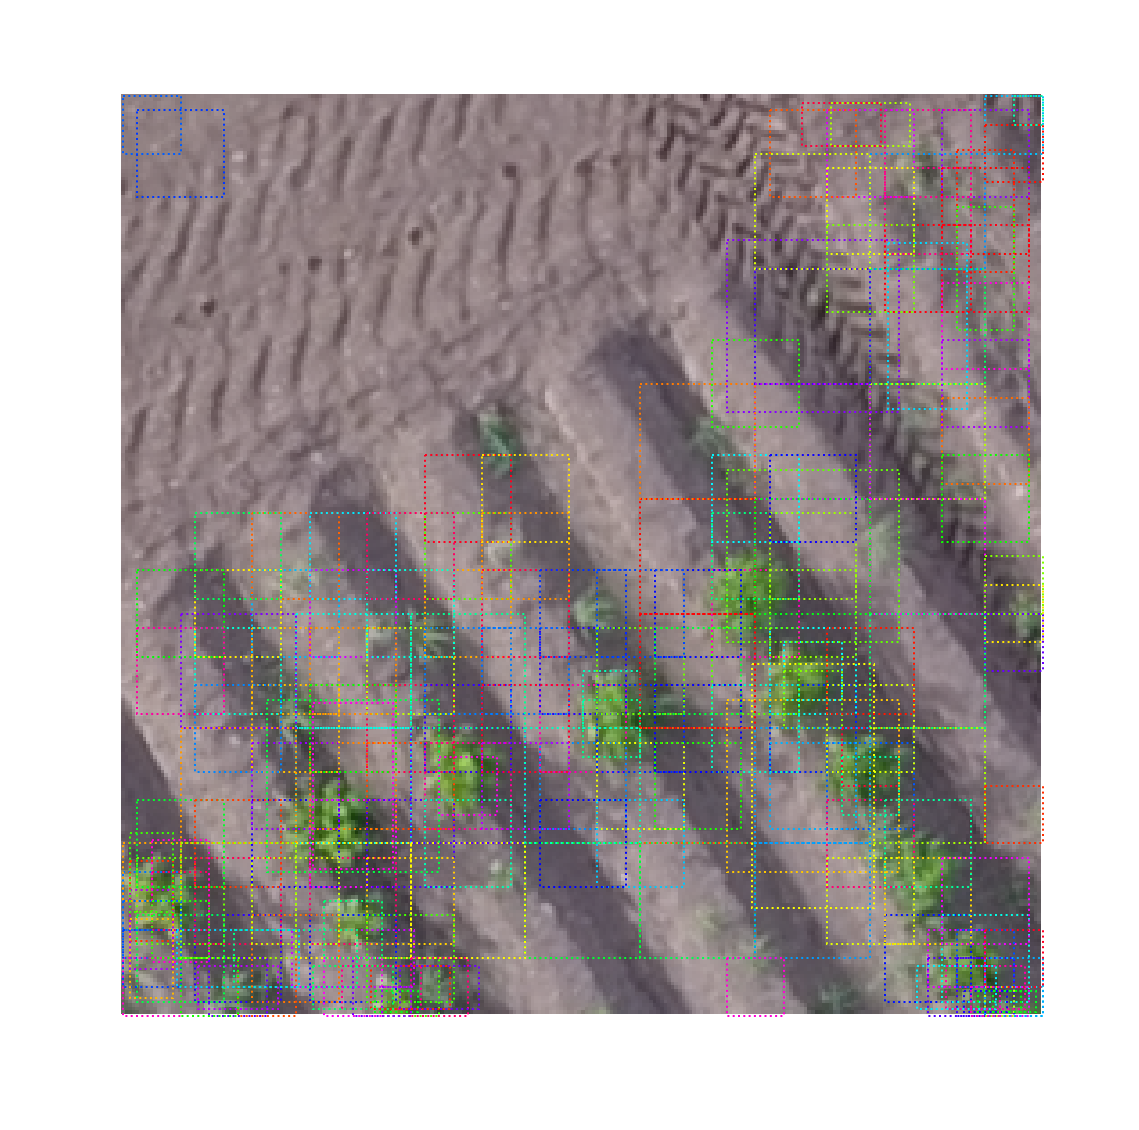

In [128]:
# Show top anchors by score (before refinement)
limit = 200
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

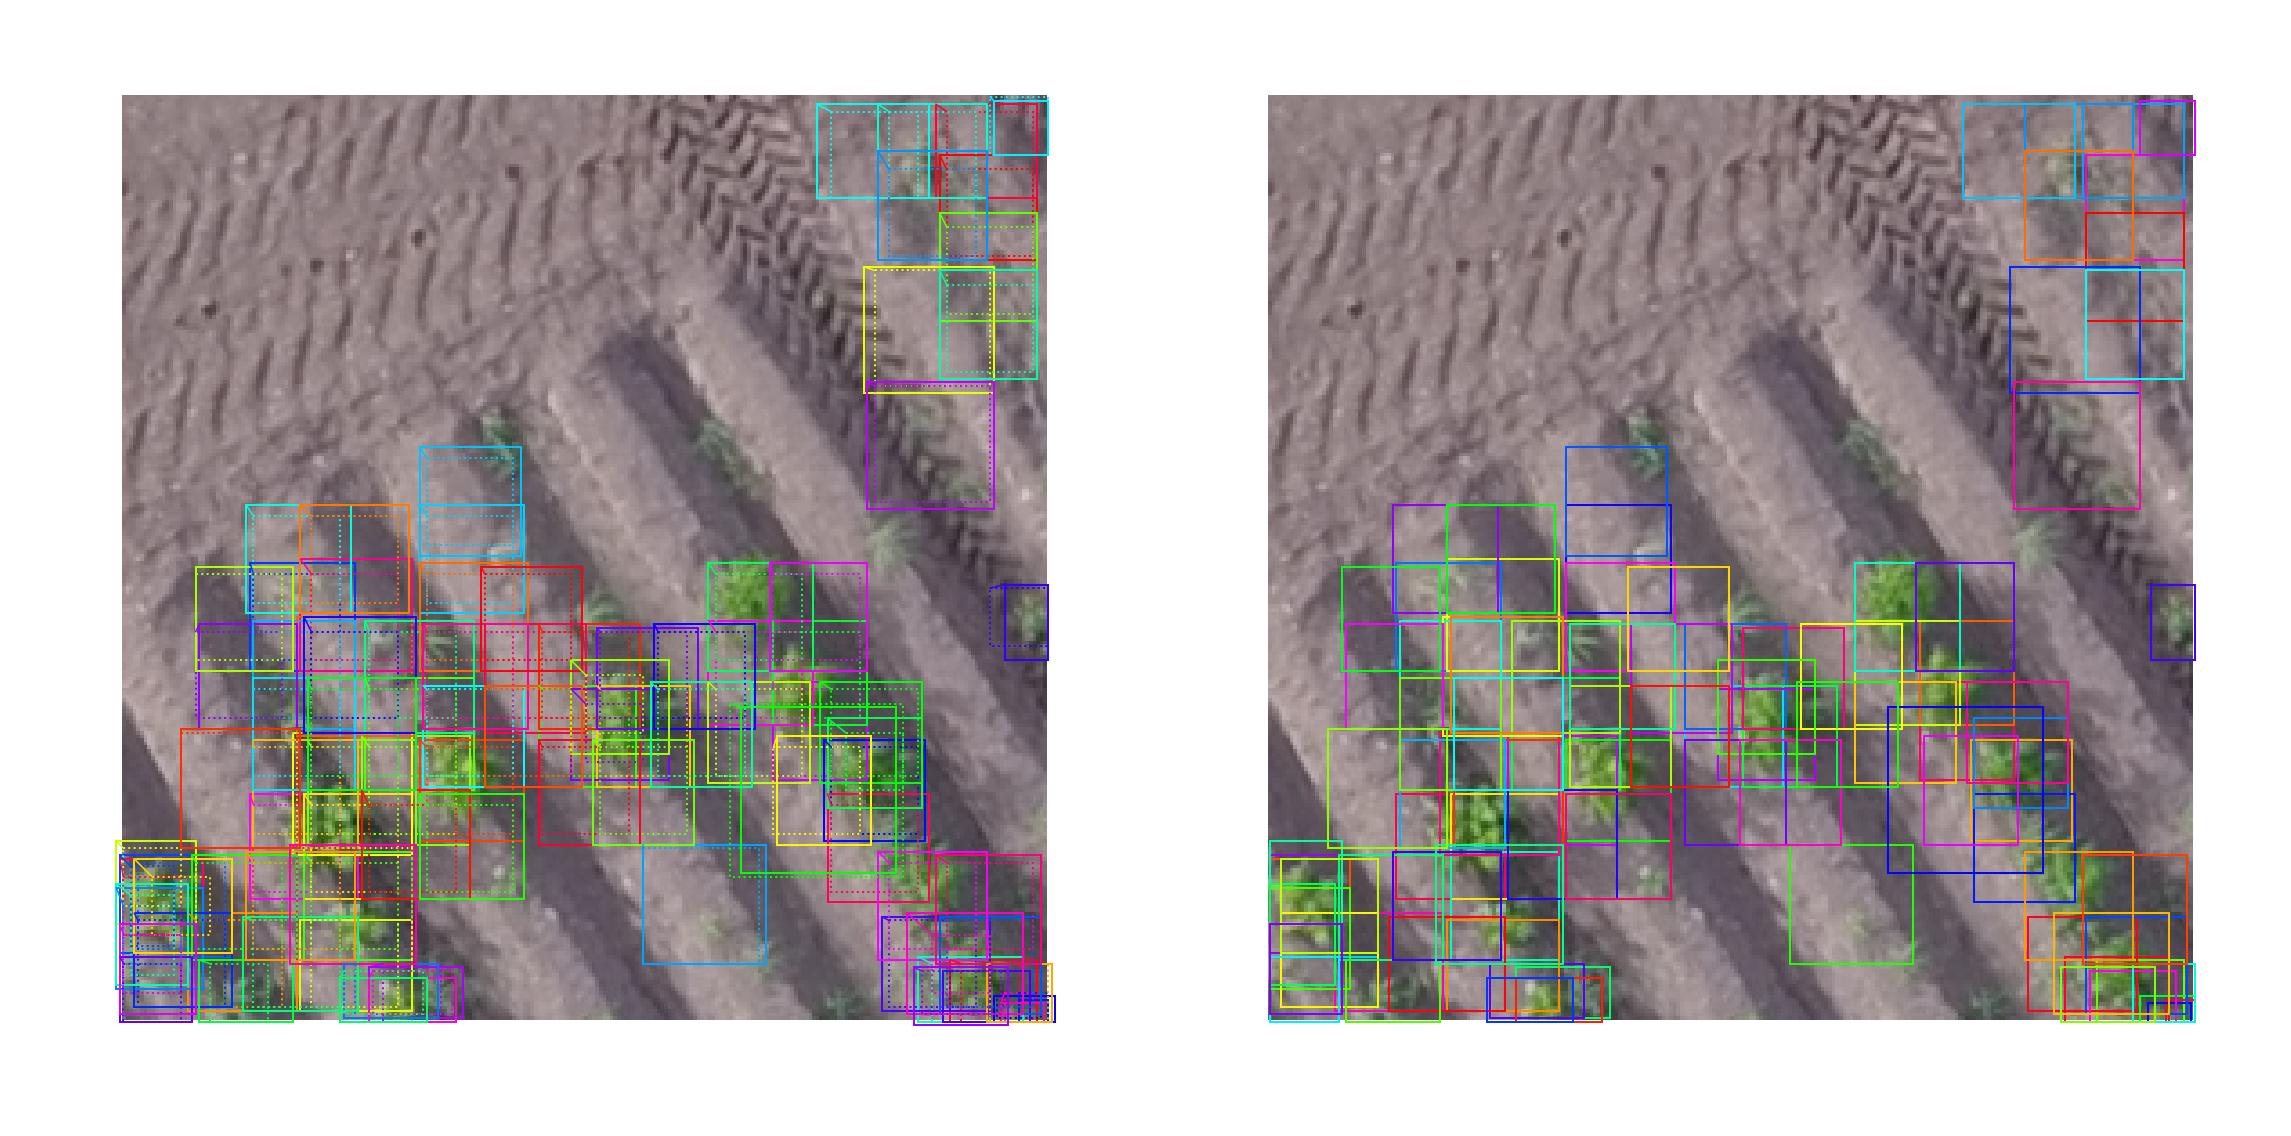

In [129]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 100
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

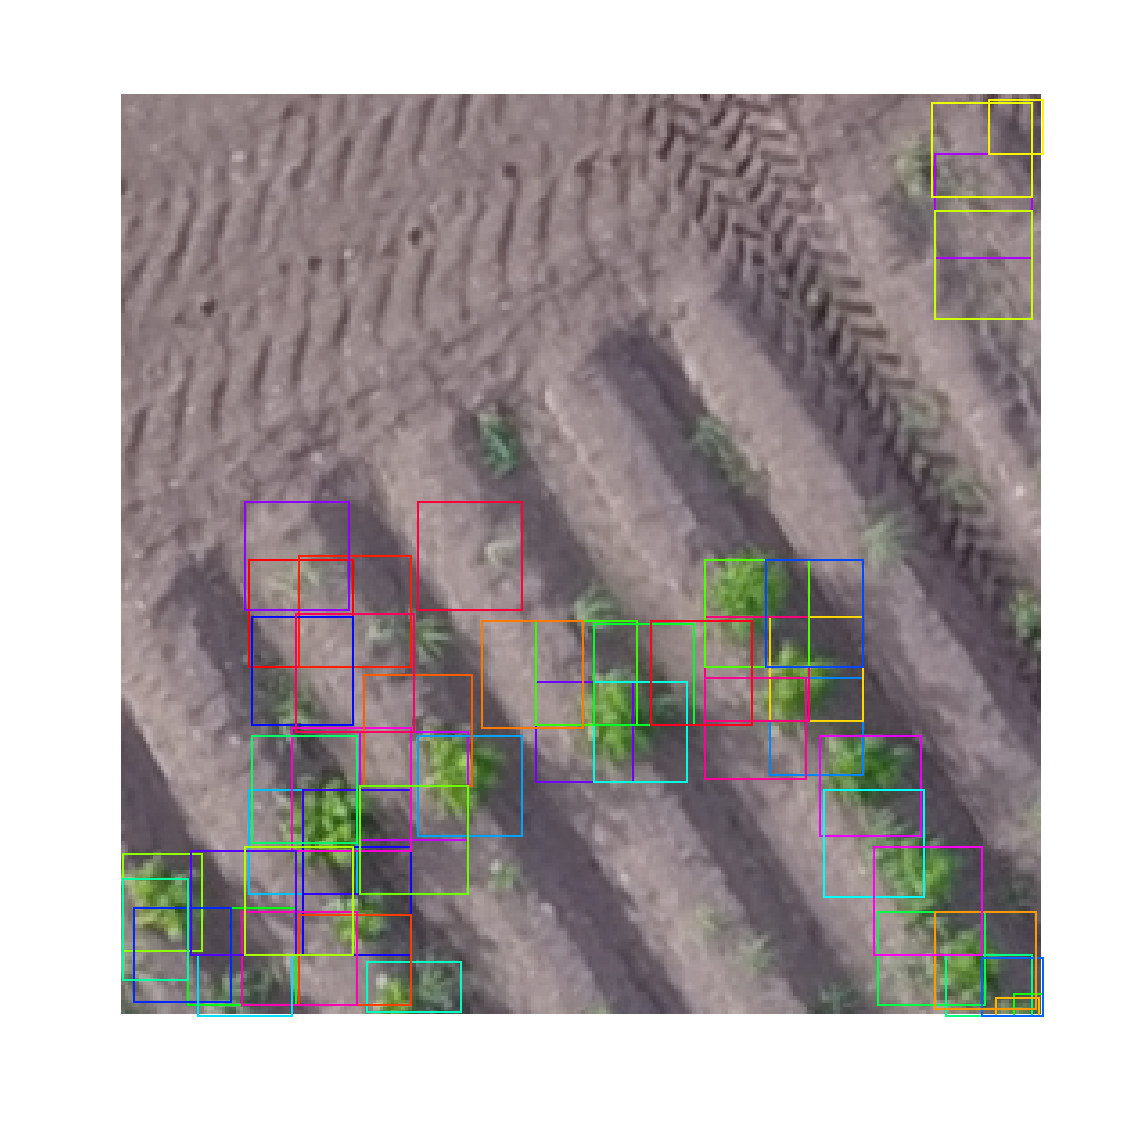

In [130]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

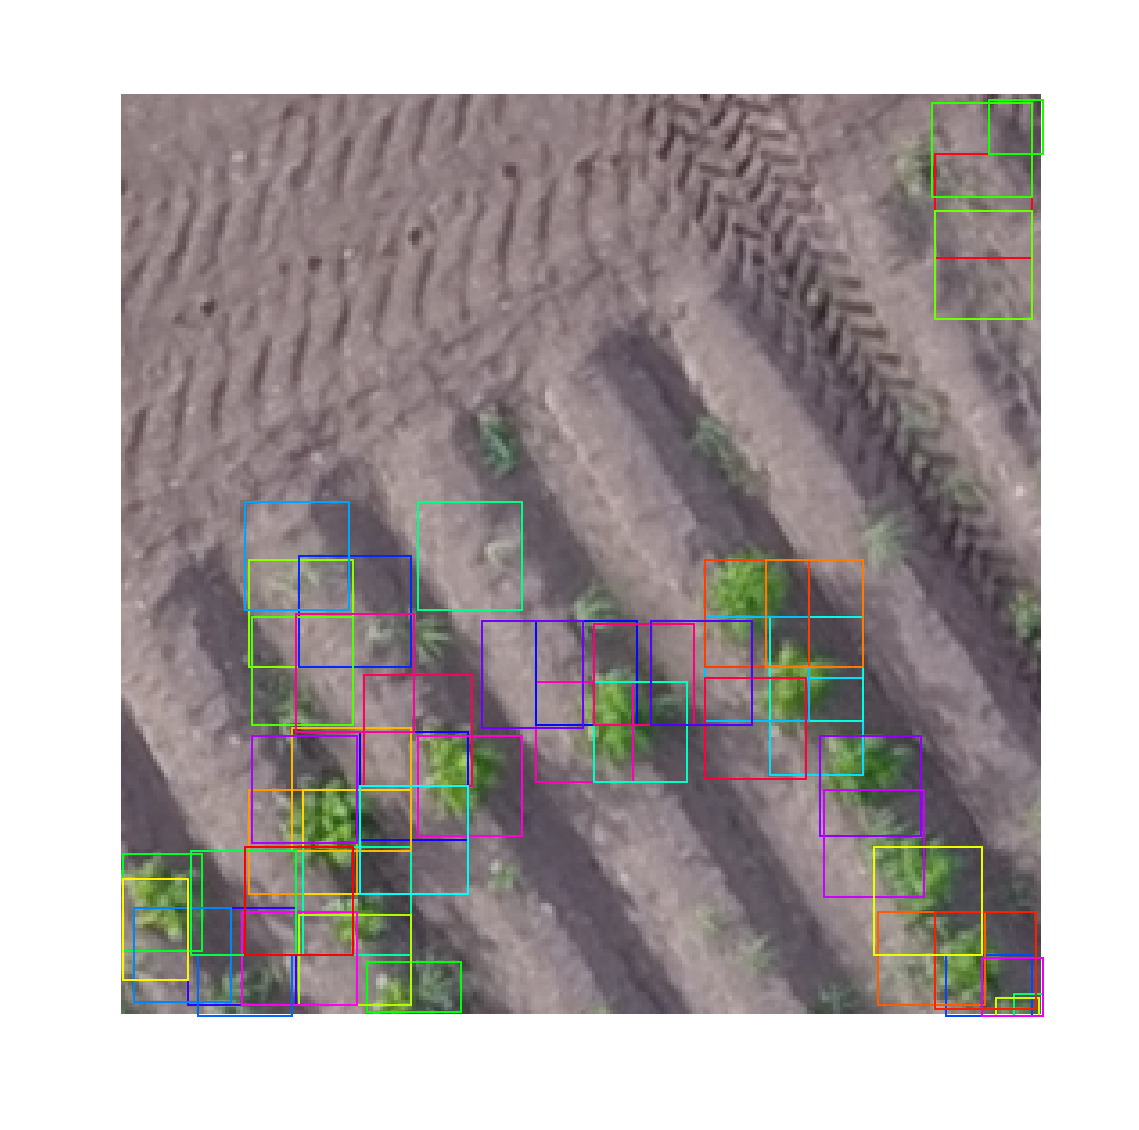

In [131]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [132]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 800, 4)           min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 800, 2)           min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 800, 2, 4)        min:   -4.15825  max:    4.84765  float32
masks                    shape: (1, 80, 28, 28, 2)    min:    0.00037  max:    0.99988  float32
detections               shape: (1, 80, 6)            min:    0.00000  max:    1.00000  float32


39 detections: ['potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato'
 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato'
 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato'
 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato'
 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato']


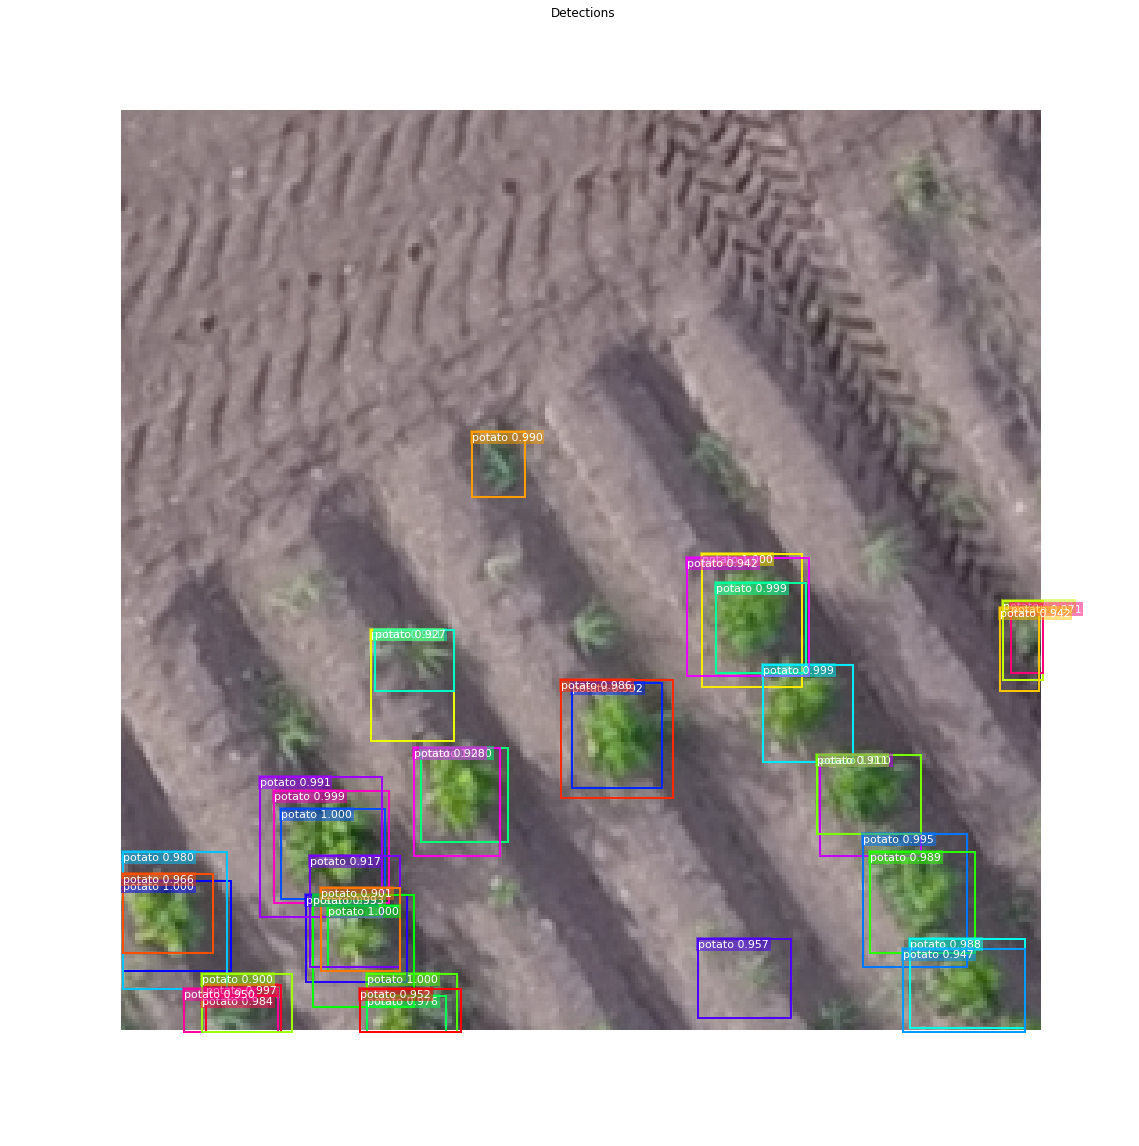

In [133]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [134]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

800 Valid proposals out of 800
144 Positive ROIs
[('BG', 656), ('potato', 144)]


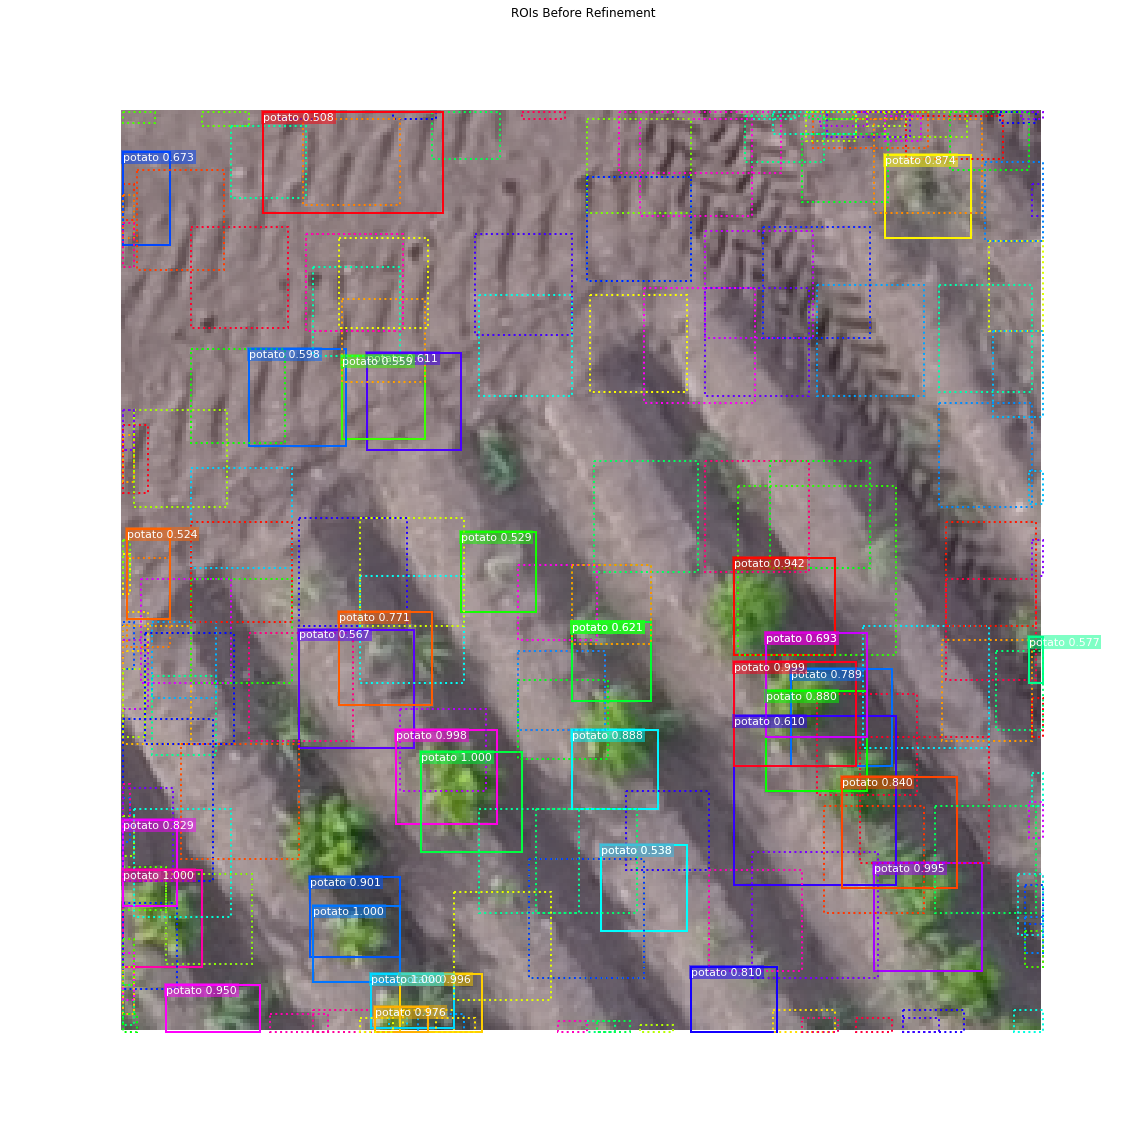

In [135]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (800, 4)              min:   -4.15825  max:    3.89047  float32
refined_proposals        shape: (800, 4)              min:   -0.02421  max:    1.01846  float32


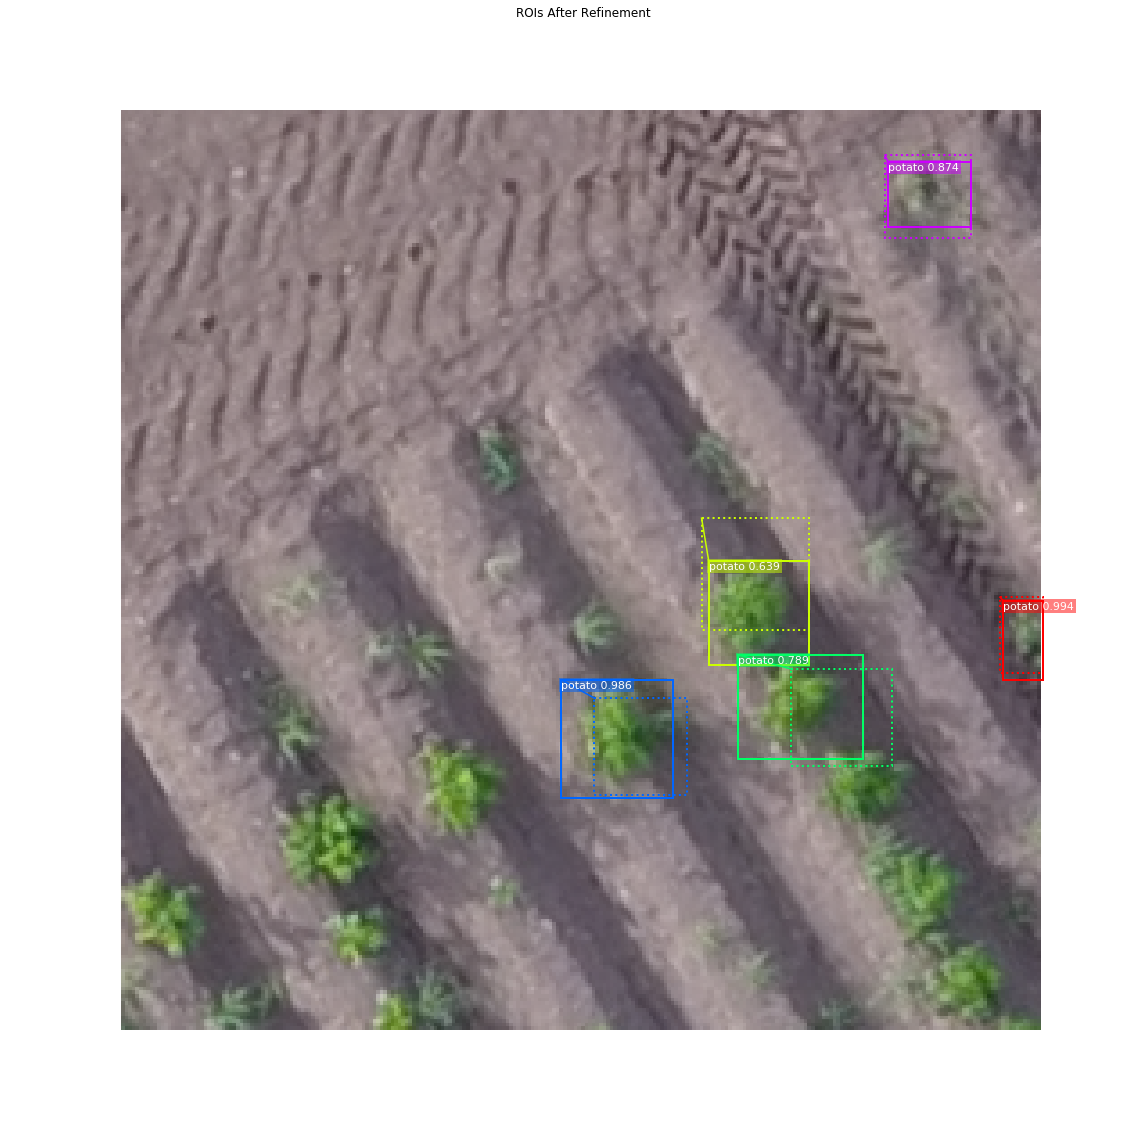

In [136]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [137]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 144 detections:
[  0   1   2   4   5   6   7   8   9  10  11  12  14  15  16  17  19  26
  27  29  39  48  50  54  56  60  61  67  68  70  77  79  88  89 100 112
 120 123 125 126 131 132 137 142 144 149 150 155 158 159 167 169 178 179
 180 182 189 192 197 204 209 210 211 220 223 226 228 229 236 239 242 244
 249 252 255 257 258 260 261 262 263 271 272 276 284 287 288 306 312 316
 319 320 325 327 328 333 335 339 341 350 352 359 386 391 411 421 430 431
 443 446 465 471 477 510 532 534 539 545 551 553 557 559 560 565 567 568
 585 589 591 608 612 613 618 621 712 722 731 755 757 761 773 792 796 797]


In [138]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 42:
[  0   1   2   7   9  10  14  15  16  19  27  29  39  56  67  68  77  89
 100 125 131 142 159 178 180 182 189 197 220 239 244 255 262 263 272 276
 288 328 477 557 567 613]


#### Per-Class Non-Max Suppression

In [139]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

potato                : [  0   1   2   7   9  10  14  15  16  19  27  29  39  56  67  68  77  89
 100 125 131 142 159 178 180 182 189 197 220 239 244 255 262 263 272 276
 288 328 477 557 567 613] -> [142   0   9 244   1  14  10   7 613 239  67  15 255 100  68 263  27  56
 180 328  19  29 178 182  77 197  16 189 220 288  89 557 125 567 477  39
 272 276 159]

Kept after per-class NMS: 39
[  0   1   7   9  10  14  15  16  19  27  29  39  56  67  68  77  89 100
 125 142 159 178 180 182 189 197 220 239 244 255 263 272 276 288 328 477
 557 567 613]


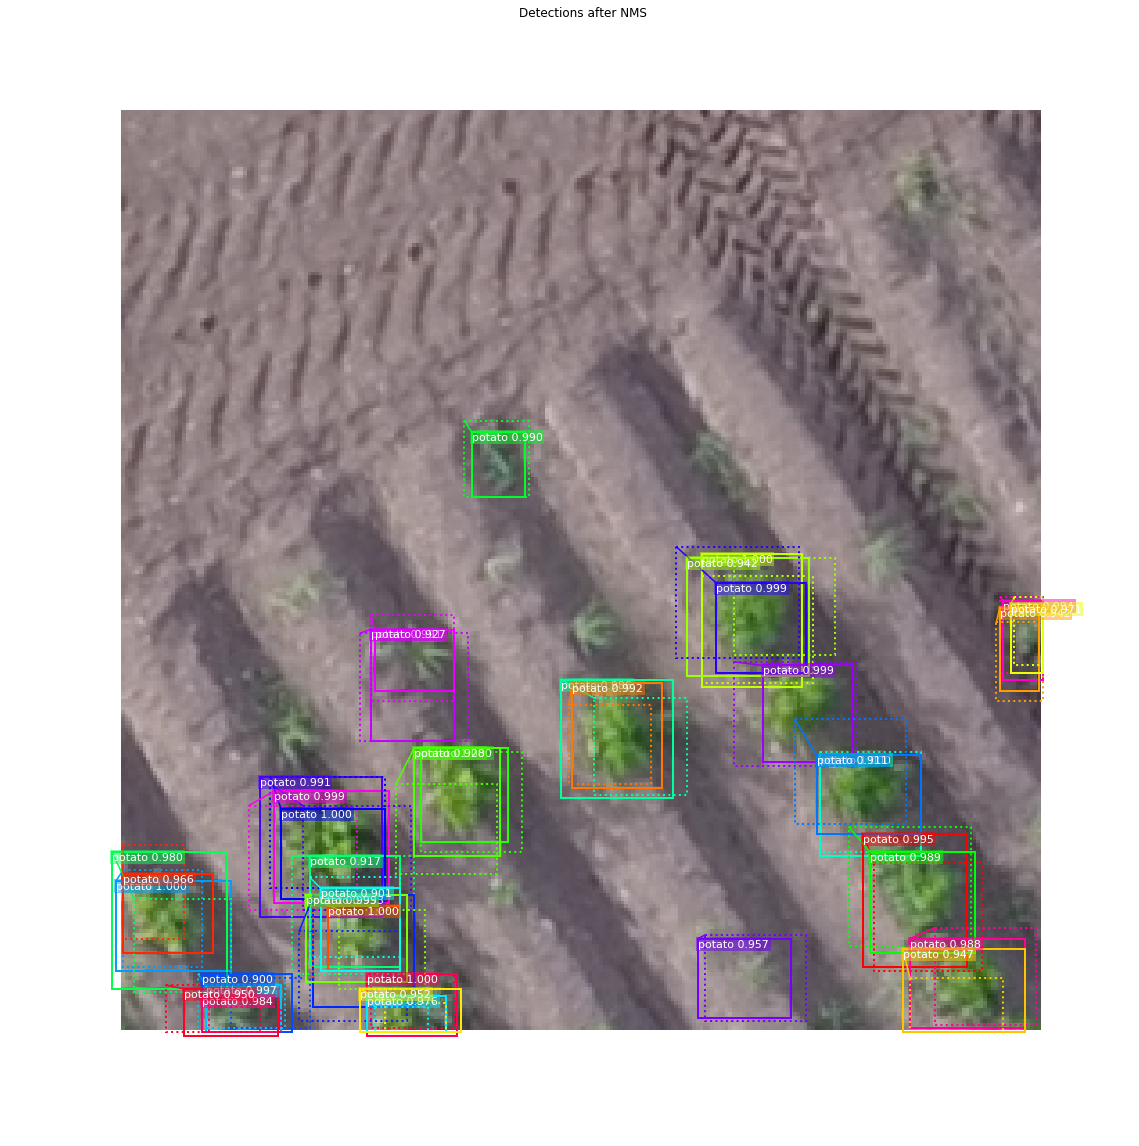

In [140]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

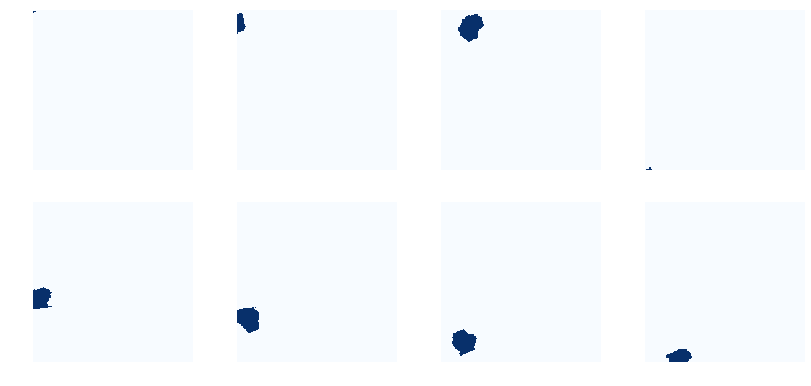

In [77]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [78]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 128, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 128, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
29 detections: ['potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato'
 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato'
 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato' 'potato'
 'potato' 'potato' 'potato' 'potato' 'potato']


In [79]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (29, 28, 28)          min:    0.00000  max:    1.00000  float32
det_masks                shape: (29, 256, 256)        min:    0.00000  max:    1.00000  bool


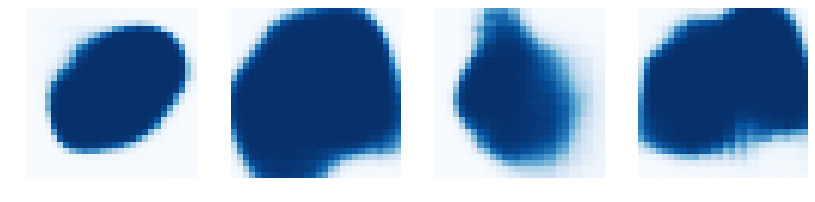

In [80]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

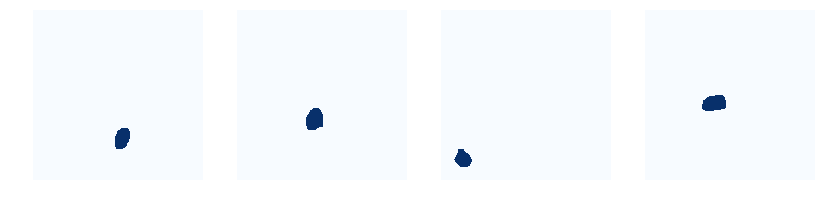

In [81]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [82]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 256, 256, 3)      min: -123.70000  max:  131.30000  float32
res2c_out                shape: (1, 64, 64, 256)      min:    0.00000  max:   16.20364  float32
res3c_out                shape: (1, 32, 32, 512)      min:    0.00000  max:   15.55470  float32
rpn_bbox                 shape: (1, 16368, 4)         min:   -8.60669  max:    5.72026  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


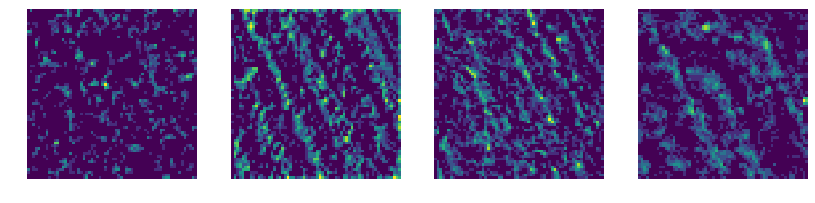

In [83]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)